<a href="https://colab.research.google.com/github/anupsen00/Predicting-Price-Hike-with-Sources-using-Different-Machine-Learning-Algorithms/blob/main/ADABOOST_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



>ADABOOST



Mean Squared Error: 323.50928947510835
R^2 Score: 0.996408929067195
Precision: 0.9724517906336089
Recall: 0.9697802197802198
Accuracy: 0.9712722298221614
F1 Score: 0.9711141678129298


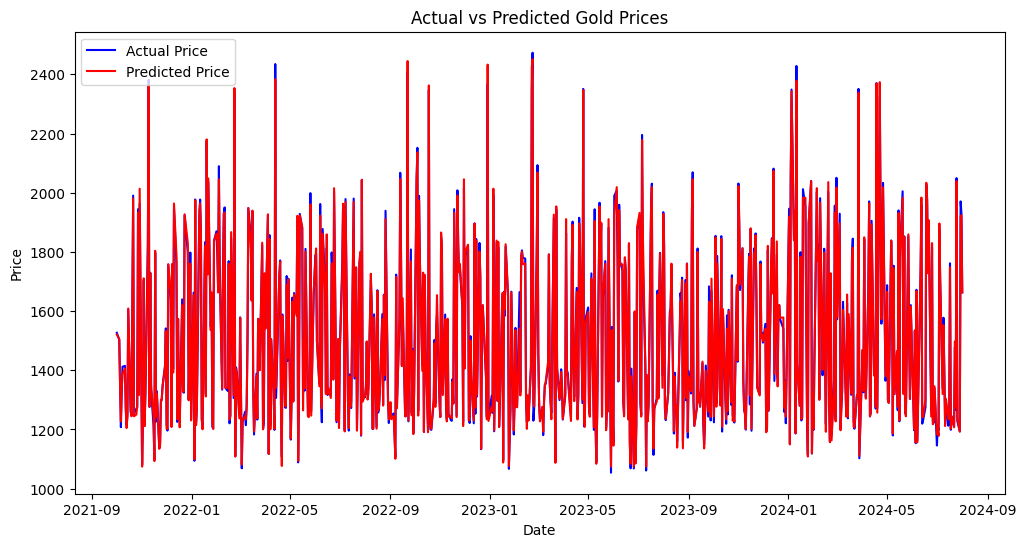

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Load the dataset
file_path = '/content/Gold Futures Historical Data (2).csv'
data = pd.read_csv(file_path)

# Data Preprocessing
def convert_volume(value):
    if isinstance(value, str):
        if 'K' in value:
            return float(value.replace('K', '')) * 1000
        elif 'M' in value:
            return float(value.replace('M', '')) * 1000000
        else:
            return float(value.replace(',', ''))
    return value  # If it's already a float

# Apply the conversion function to the 'Vol.' column
data['Vol.'] = data['Vol.'].apply(convert_volume)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Convert other columns to numeric
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].astype(str).str.replace(',', '', regex=False)
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Handle the 'Change %' column
data['Change %'] = data['Change %'].astype(str).str.strip().str.replace('%', '', regex=False)
data['Change %'] = pd.to_numeric(data['Change %'], errors='coerce')

# Check and handle missing values for each column
for col in data.columns:
    if data[col].isnull().sum() > 0:
        if col == 'Vol.':  # Fill 'Vol.' with median
            data[col].fillna(data[col].median(), inplace=True)
        elif col in ['Price', 'Open', 'High', 'Low']:  # Numeric columns with iterative imputation
            imputer = IterativeImputer()
            data[[col]] = imputer.fit_transform(data[[col]])
        elif col == 'Change %':  # Choose an appropriate fill strategy for 'Change %'
            data[col].fillna(data[col].mean(), inplace=True)  # Here using mean as an example
        else:
            data.dropna(subset=[col], inplace=True)  # Drop rows with missing data in non-essential columns

# Drop rows with any remaining missing values (e.g., in 'Date' or other non-numeric columns)
data.dropna(inplace=True)

# Sort by date
data.sort_values(by='Date', inplace=True)

# Feature Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Price', 'Open', 'High', 'Low', 'Vol.']])
# Create sequences for AdaBoost model
X = []
y = []


window_size = 60

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i].flatten())  # Flatten the sequence to a vector
    y.append(scaled_data[i, 0])  # Predicting 'Price' column

X = np.array(X)
y = np.array(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the AdaBoost model
base_regressor = DecisionTreeRegressor(max_depth=5)
model = AdaBoostRegressor(estimator=base_regressor, n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)

# Reverse the scaling for better interpretability
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 4))), axis=1))[:, 0]
y_pred_actual = scaler.inverse_transform(np.concatenate((y_pred.reshape(-1, 1), np.zeros((len(y_pred), 4))), axis=1))[:, 0]

# Calculate performance metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Convert regression output to classification for metrics
threshold = 0.01  # Example threshold
y_test_binary = (np.diff(y_test_actual) > threshold).astype(int)
y_pred_binary = (np.diff(y_pred_actual) > threshold).astype(int)

# Calculate classification metrics
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
accuracy = accuracy_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

# Plot Actual vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][-len(y_test_actual):], y_test_actual, color='blue', label='Actual Price')
plt.plot(data['Date'][-len(y_pred_actual):], y_pred_actual, color='red', label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Gold Prices')
plt.legend()
plt.show()


<ipython-input-12-0ab70384e69a>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_window[-1] = next_pred_scaled  # Place the prediction at the end
<ipython-input-12-0ab70384e69a>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_window[-1] = next_pred_scaled  # Place the prediction at the end
<ipython-input-12-0ab70384e69a>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_window[-1] = next_pred_scaled  # Place the prediction at the end
<ipython-inpu

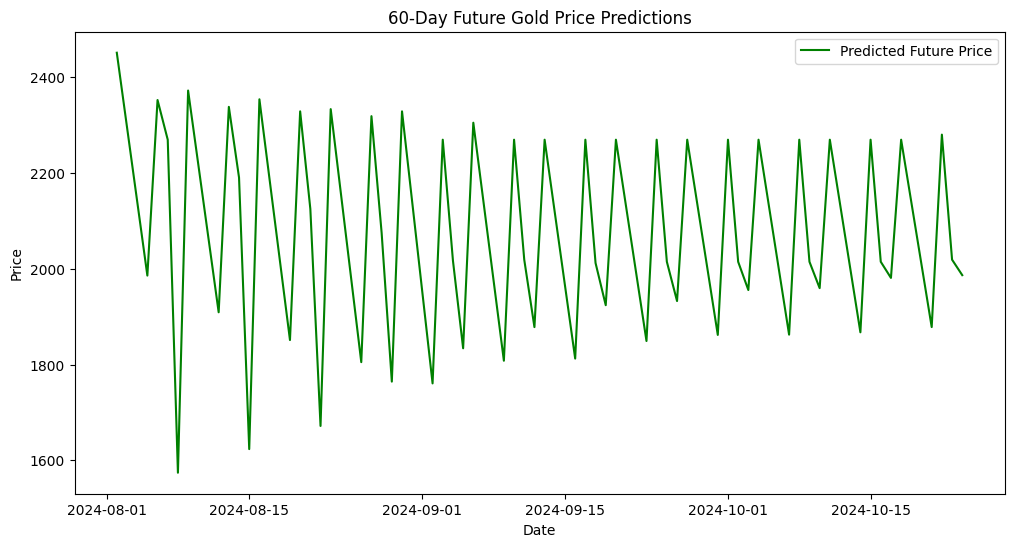

In [ ]:
# Start with the last `window_size` days of data
last_window = scaled_data[-window_size:].flatten()

# List to store future predictions
future_predictions = []

# Predict the next 60 days
for _ in range(60):
    # Reshape last window for model prediction
    input_data = last_window.reshape(1, -1)

    # Predict the next price
    next_pred_scaled = model.predict(input_data)

    # Append prediction to the list (for scaling back later)
    future_predictions.append(next_pred_scaled[0])

    # Update the last window by appending the new prediction and removing the oldest value
    last_window = np.roll(last_window, -1)
    last_window[-1] = next_pred_scaled  # Place the prediction at the end

# Inverse transform the predictions back to the original scale
future_predictions_actual = scaler.inverse_transform(
    np.concatenate((np.array(future_predictions).reshape(-1, 1), np.zeros((60, 4))), axis=1)
)[:, 0]

# Generate future dates
last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(last_date, periods=61, freq='B')[1:]  # Skipping the last date and using business days

# Plotting the predicted future prices
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions_actual, color='green', label='Predicted Future Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('60-Day Future Gold Price Predictions')
plt.legend()
plt.show()


Mean Squared Error: 323.50928947510835
R^2 Score: 0.996408929067195
Precision: 0.9972375690607734
Recall: 0.9863387978142076
Accuracy: 0.9918032786885246
F1 Score: 0.9917582417582418


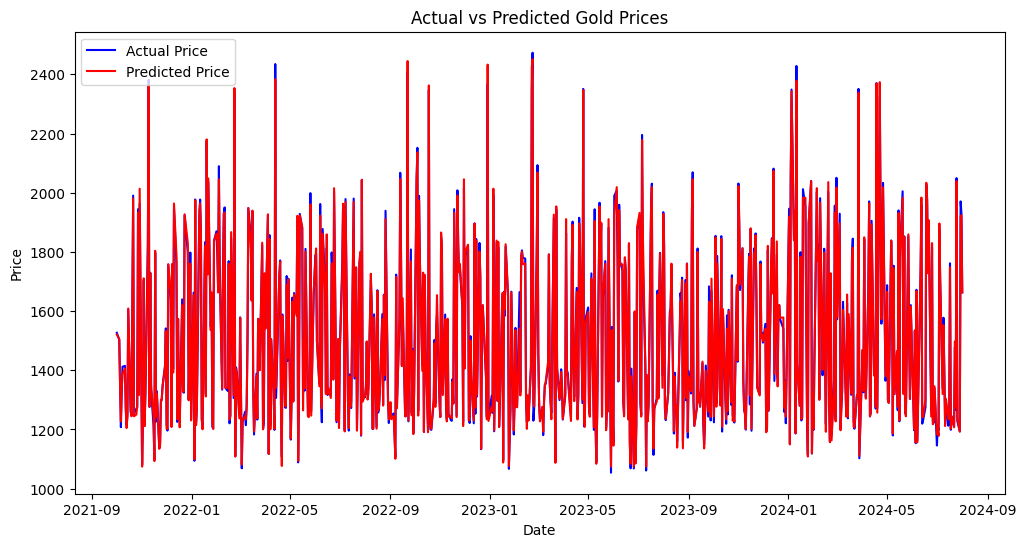

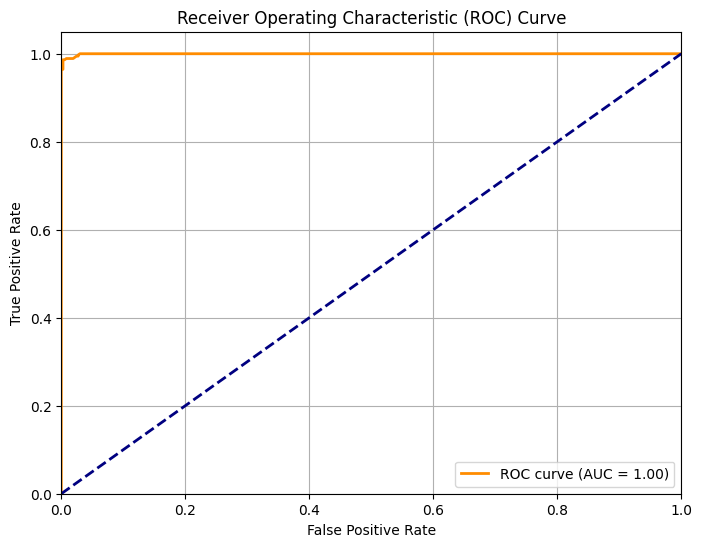

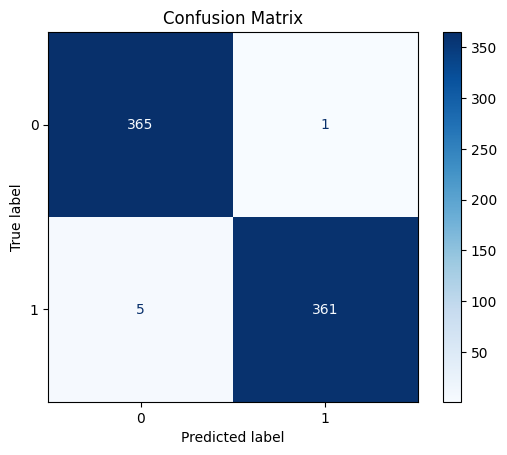

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Load the dataset
file_path = '/content/Gold Futures Historical Data (2).csv'
data = pd.read_csv(file_path)

# Data Preprocessing
def convert_volume(value):
    if isinstance(value, str):
        if 'K' in value:
            return float(value.replace('K', '')) * 1000
        elif 'M' in value:
            return float(value.replace('M', '')) * 1000000
        else:
            return float(value.replace(',', ''))
    return value  # If it's already a float

# Apply the conversion function to the 'Vol.' column
data['Vol.'] = data['Vol.'].apply(convert_volume)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Convert other columns to numeric
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].astype(str).str.replace(',', '', regex=False)
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Handle the 'Change %' column
data['Change %'] = data['Change %'].astype(str).str.strip().str.replace('%', '', regex=False)
data['Change %'] = pd.to_numeric(data['Change %'], errors='coerce')

# Check and handle missing values for each column
for col in data.columns:
    if data[col].isnull().sum() > 0:
        if col == 'Vol.':  # Fill 'Vol.' with median
            data[col].fillna(data[col].median(), inplace=True)
        elif col in ['Price', 'Open', 'High', 'Low']:  # Numeric columns with iterative imputation
            imputer = IterativeImputer()
            data[[col]] = imputer.fit_transform(data[[col]])
        elif col == 'Change %':  # Choose an appropriate fill strategy for 'Change %'
            data[col].fillna(data[col].mean(), inplace=True)  # Here using mean as an example
        else:
            data.dropna(subset=[col], inplace=True)  # Drop rows with missing data in non-essential columns

# Drop rows with any remaining missing values (e.g., in 'Date' or other non-numeric columns)
data.dropna(inplace=True)

# Sort by date
data.sort_values(by='Date', inplace=True)

# Feature Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Price', 'Open', 'High', 'Low', 'Vol.']])
# Create sequences for AdaBoost model
X = []
y = []

window_size = 60

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i].flatten())  # Flatten the sequence to a vector
    y.append(scaled_data[i, 0])  # Predicting 'Price' column

X = np.array(X)
y = np.array(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the AdaBoost model
base_regressor = DecisionTreeRegressor(max_depth=5)
model = AdaBoostRegressor(estimator=base_regressor, n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)

# Reverse the scaling for better interpretability
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 4))), axis=1))[:, 0]
y_pred_actual = scaler.inverse_transform(np.concatenate((y_pred.reshape(-1, 1), np.zeros((len(y_pred), 4))), axis=1))[:, 0]

# Calculate performance metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Convert regression output to binary classification based on a threshold
price_threshold = np.median(y_test_actual)  # You can adjust this threshold
y_test_binary = (y_test_actual > price_threshold).astype(int)
y_pred_binary = (y_pred_actual > price_threshold).astype(int)

# Calculate classification metrics
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
accuracy = accuracy_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

# Plot Actual vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][-len(y_test_actual):], y_test_actual, color='blue', label='Actual Price')
plt.plot(data['Date'][-len(y_pred_actual):], y_pred_actual, color='red', label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Gold Prices')
plt.legend()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_actual)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


<ipython-input-18-0ab70384e69a>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_window[-1] = next_pred_scaled  # Place the prediction at the end
<ipython-input-18-0ab70384e69a>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_window[-1] = next_pred_scaled  # Place the prediction at the end
<ipython-input-18-0ab70384e69a>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_window[-1] = next_pred_scaled  # Place the prediction at the end
<ipython-inpu

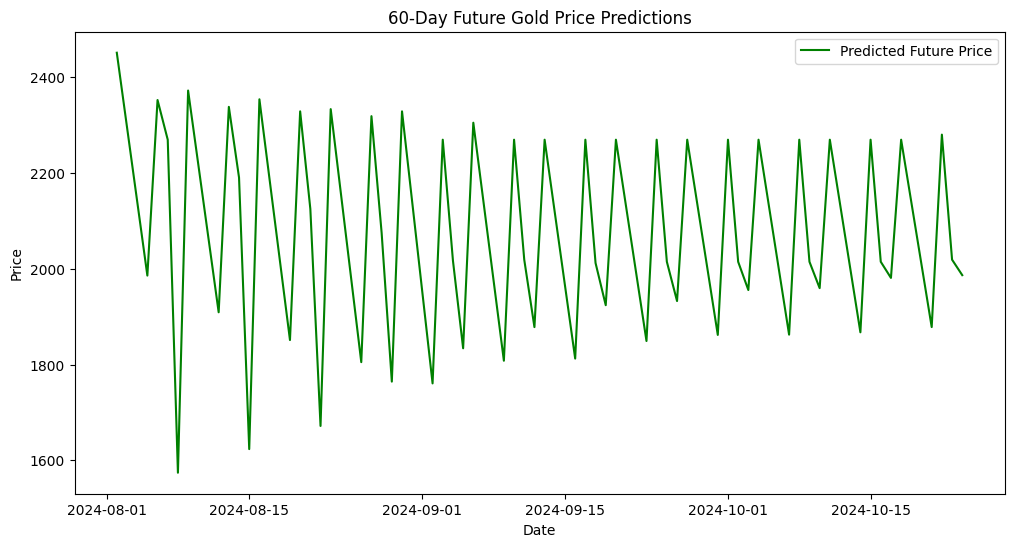

In [ ]:
# Start with the last `window_size` days of data
last_window = scaled_data[-window_size:].flatten()

# List to store future predictions
future_predictions = []

# Predict the next 60 days
for _ in range(60):
    # Reshape last window for model prediction
    input_data = last_window.reshape(1, -1)

    # Predict the next price
    next_pred_scaled = model.predict(input_data)

    # Append prediction to the list (for scaling back later)
    future_predictions.append(next_pred_scaled[0])

    # Update the last window by appending the new prediction and removing the oldest value
    last_window = np.roll(last_window, -1)
    last_window[-1] = next_pred_scaled  # Place the prediction at the end

# Inverse transform the predictions back to the original scale
future_predictions_actual = scaler.inverse_transform(
    np.concatenate((np.array(future_predictions).reshape(-1, 1), np.zeros((60, 4))), axis=1)
)[:, 0]

# Generate future dates
last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(last_date, periods=61, freq='B')[1:]  # Skipping the last date and using business days

# Plotting the predicted future prices
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions_actual, color='green', label='Predicted Future Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('60-Day Future Gold Price Predictions')
plt.legend()
plt.show()